In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [40]:
app_dir = '/Users/paramshah/Documents/Param/NYU/courses/Machine Learning/Project/Github Team/covid-19'

In [41]:
_type = 'cases'

In [42]:
df = pd.read_csv(os.path.join(app_dir, f'data/staging/jhu_{_type}.csv'))
df['date'] = pd.to_datetime(df['date'])

In [43]:
mostrecentdate = str(df['date'].max())

In [32]:
df = pd.read_csv('https://raw.githubusercontent.com/DataHerb/dataset-covid-19/master/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')


In [33]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 5/16/20


,5/16/20
Country/Region,
US,1467820
Russia,272043
United Kingdom,241461
Brazil,233511
Spain,230698
...,...
Mozambique,129
Yemen,122
Cambodia,122


In [37]:
df[df['Country/Region'] == "US"].iloc[:,4:].T.sum(axis = 1)['cases']

KeyError: 'cases'

In [38]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country]['cases'].values
    co = pd.DataFrame(co)
    co.columns = ['cases']
    co = co.loc[co['cases'] > 0]
    
    y = np.array(co['cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



United States

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 1417774
	Confirmed cases on 106 	 1257023
	Ratio: 1.13
	Weekly increase: 12.8 %
	Daily increase: 1.7 % per day
	Doubling Time (represents recent growth): 40.3 days

** Based on Logistic Fit**

	R^2: 0.9967846358519855
	Doubling Time (during middle of growth):  14.38 (± 0.73 ) days


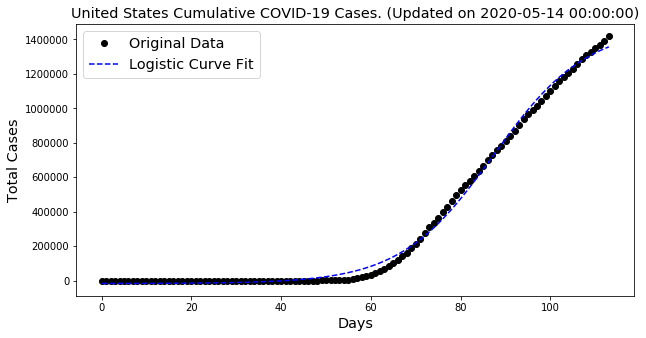



India

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 81997
	Confirmed cases on 106 	 56351
	Ratio: 1.46
	Weekly increase: 45.5 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.9 days

** Based on Logistic Fit**

	R^2: 0.9986865669414028
	Doubling Time (during middle of growth):  16.37 (± 0.67 ) days

** Based on Exponential Fit **

	R^2: 0.9946693313596902
	Doubling Time (represents overall growth):  10.39 (± 0.32 ) days


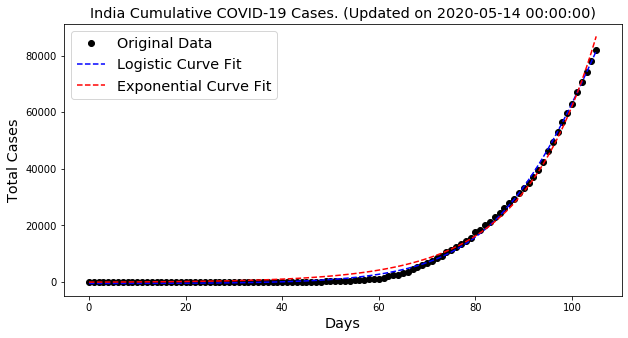



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 223096
	Confirmed cases on 106 	 215858
	Ratio: 1.03
	Weekly increase: 3.4 %
	Daily increase: 0.5 % per day
	Doubling Time (represents recent growth): 147.1 days

** Based on Logistic Fit**

	R^2: 0.9970829680677588
	Doubling Time (during middle of growth):  14.57 (± 0.7 ) days


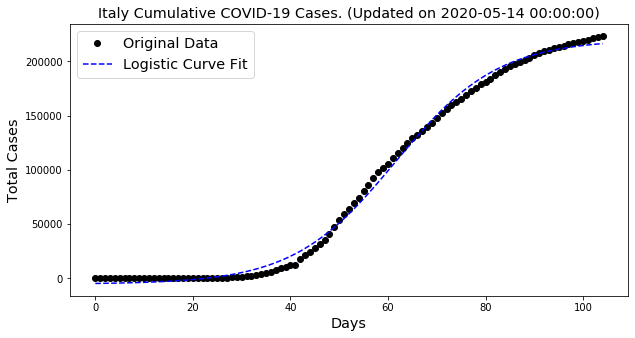



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 74781
	Confirmed cases on 106 	 66201
	Ratio: 1.13
	Weekly increase: 13.0 %
	Daily increase: 1.8 % per day
	Doubling Time (represents recent growth): 39.8 days

** Based on Logistic Fit**

	R^2: 0.9981912661223239
	Doubling Time (during middle of growth):  14.95 (± 0.59 ) days


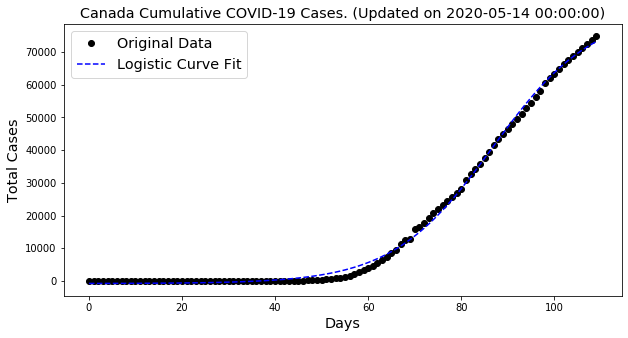



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 229540
	Confirmed cases on 106 	 221447
	Ratio: 1.04
	Weekly increase: 3.7 %
	Daily increase: 0.5 % per day
	Doubling Time (represents recent growth): 135.2 days

** Based on Logistic Fit**

	R^2: 0.9978839963824709
	Doubling Time (during middle of growth):  10.18 (± 0.42 ) days


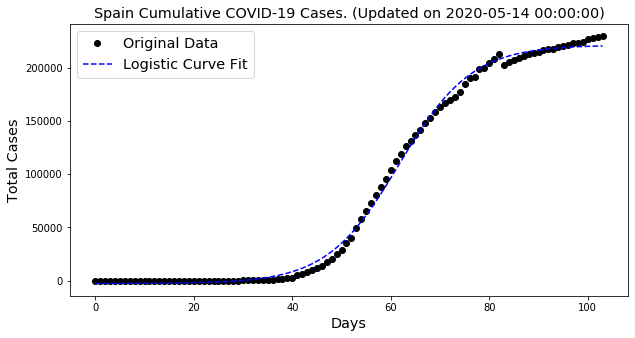



France

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 178994
	Confirmed cases on 106 	 174918
	Ratio: 1.02
	Weekly increase: 2.3 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 210.6 days

** Based on Logistic Fit**

	R^2: 0.9977117654906356
	Doubling Time (during middle of growth):  10.19 (± 0.43 ) days


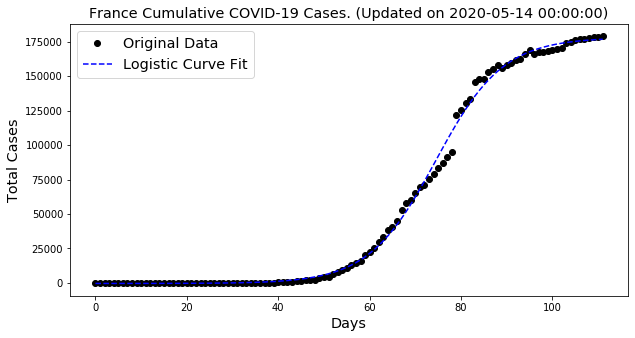



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 234440
	Confirmed cases on 106 	 207977
	Ratio: 1.13
	Weekly increase: 12.7 %
	Daily increase: 1.7 % per day
	Doubling Time (represents recent growth): 40.5 days

** Based on Logistic Fit**

	R^2: 0.9972830404420966
	Doubling Time (during middle of growth):  14.55 (± 0.71 ) days


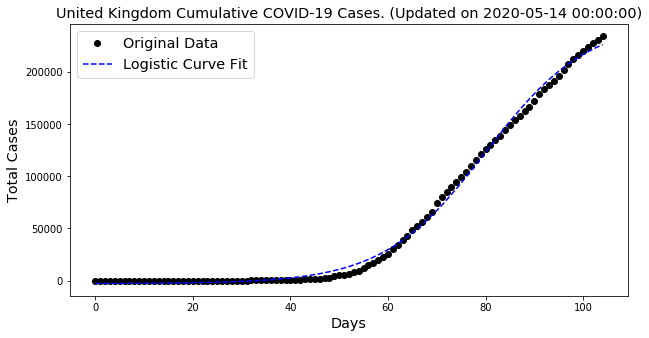



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 3143
	Confirmed cases on 106 	 2543
	Ratio: 1.24
	Weekly increase: 23.6 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 22.9 days

** Based on Logistic Fit**

	R^2: 0.9902171847458625
	Doubling Time (during middle of growth):  31.78 (± 7.49 ) days


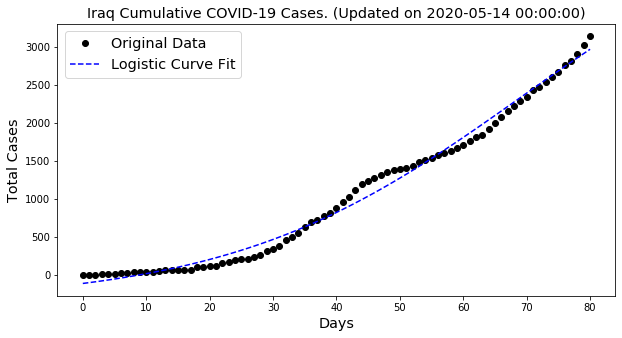



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 16120
	Confirmed cases on 106 	 15477
	Ratio: 1.04
	Weekly increase: 4.2 %
	Daily increase: 0.6 % per day
	Doubling Time (represents recent growth): 119.2 days

** Based on Logistic Fit**

	R^2: 0.9986021307114646
	Doubling Time (during middle of growth):  10.31 (± 0.34 ) days


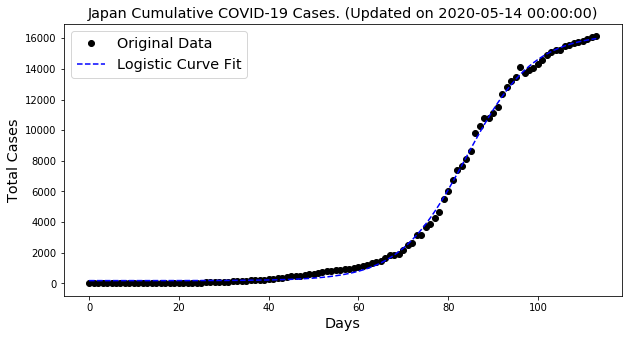



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 174478
	Confirmed cases on 106 	 169430
	Ratio: 1.03
	Weekly increase: 3.0 %
	Daily increase: 0.4 % per day
	Doubling Time (represents recent growth): 165.3 days

** Based on Logistic Fit**

	R^2: 0.997733473743439
	Doubling Time (during middle of growth):  10.57 (± 0.44 ) days


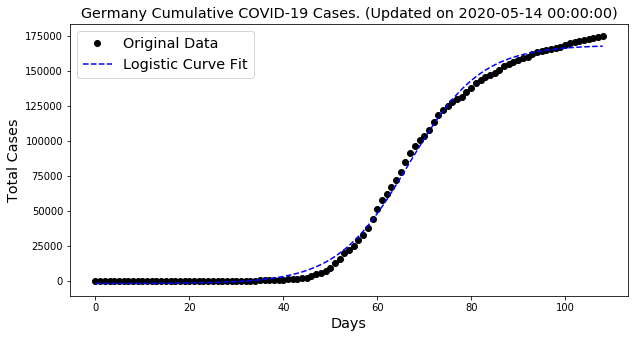



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 113 	 203165
	Confirmed cases on 106 	 135773
	Ratio: 1.5
	Weekly increase: 49.6 %
	Daily increase: 5.9 % per day
	Doubling Time (represents recent growth): 12.0 days

** Based on Logistic Fit**

	R^2: 0.9994081185095642
	Doubling Time (during middle of growth):  17.24 (± 0.64 ) days


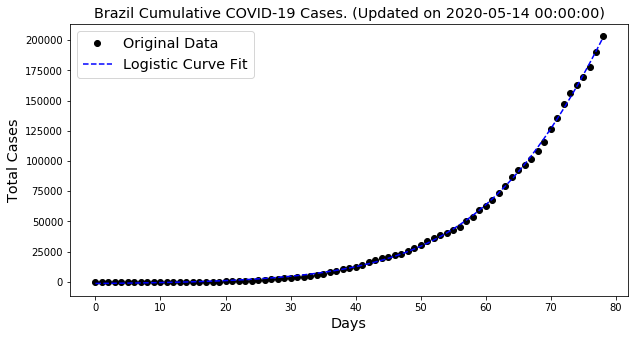

In [44]:
topcountries = df.country.unique()
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'country', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')